In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/apple/.kaggle: File exists


In [4]:
!kaggle competitions download -c ppcu-data-mining-and-machine-learning-2025
!unzip ppcu-data-mining-and-machine-learning-2025.zip

ppcu-data-mining-and-machine-learning-2025.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ppcu-data-mining-and-machine-learning-2025.zip
replace X_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score
)

X_train = pd.read_csv('X_train.csv', na_values='na')
X_train_full = X_train.copy()
y_train = pd.read_csv('y_train.csv', na_values='na')
X_test = pd.read_csv('X_test.csv', na_values='na')

In [6]:
y_train = y_train.replace({
    'pos': 1,
    'neg': 0
})
y_train = y_train.drop(columns=["Id"])

/var/folders/yg/y3vwqrws7p30yq14jzl82vqc0000gn/T/ipykernel_42617/2198835226.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({


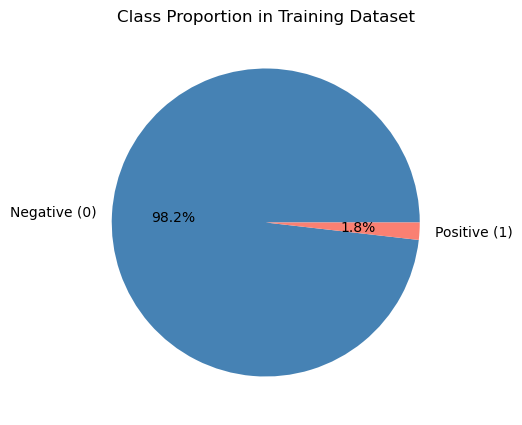

In [7]:
class_counts = y_train.value_counts().sort_index()
total = class_counts.sum()

imbalance_ratio = class_counts[1] / class_counts[0]
plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=['Negative (0)', 'Positive (1)'], autopct='%1.1f%%', colors=['steelblue', 'salmon'])
plt.title('Class Proportion in Training Dataset')
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [9]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 48000 entries, 10969 to 26945
Columns: 170 entries, aa_000 to eg_000
dtypes: float64(169), int64(1)
memory usage: 62.6 MB


In [ ]:
missing_percentage = X_train.isnull().sum() / len(X_train) * 100
missing_df = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
remove_missing_cols = missing_percentage[missing_percentage > 50].index.to_list()

In [ ]:
X_train = X_train.drop(columns=remove_missing_cols)
X_val = X_val.drop(columns=remove_missing_cols)
X_test = X_test.drop(columns=remove_missing_cols)

In [ ]:
imputation_values = X_train.median()
X_train = X_train.fillna(imputation_values)
X_val = X_val.fillna(imputation_values)
X_test = X_test.fillna(imputation_values)

In [ ]:
def count_huge_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR

    outlier_count = ((series < lower_bound) | (series > upper_bound)).sum()

    return outlier_count

outlier_counts = {}
for col in X_train.columns:
    outlier_counts[col] = count_huge_outliers(X_train[col])

outlier_df = pd.Series(outlier_counts).to_frame(name='Outlier Count')
outlier_df.sort_values(by='Outlier Count', ascending=False, inplace=True)

features_with_outliers = outlier_df[outlier_df['Outlier Count'] > 0]
features_with_outliers

,Outlier Count
az_007,11410
cl_000,10881
dr_000,10240
dq_000,10120
cj_000,10022
...,...
cs_008,124
db_000,109
au_000,46
as_000,18


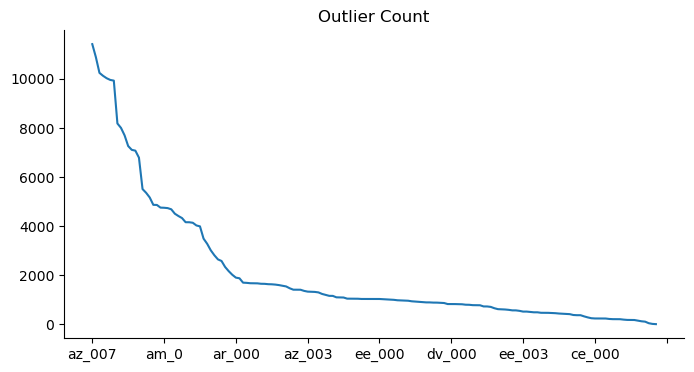

In [ ]:
from matplotlib import pyplot as plt
features_with_outliers['Outlier Count'].plot(kind='line', figsize=(8, 4), title='Outlier Count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
print(X_train.aa_000.max())
print(X_train.aa_000.min())
print(X_test.aa_000.max())
print(X_test.aa_000.min())

42949672
0
2046336
0


In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler = RobustScaler()

scaler.set_output(transform="pandas")

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


scaler2 = StandardScaler()

scaler2.set_output(transform="pandas")

scaler2.fit(X_train)

X_train = scaler2.transform(X_train)
X_val = scaler2.transform(X_val)
X_test = scaler2.transform(X_test)


In [ ]:
print(X_train.aa_000.max())
print(X_train.aa_000.min())
print(X_test.aa_000.max())
print(X_test.aa_000.min())

136.43609748379944
-0.19769724892457052
6.3122163303498775
-0.19769724892457052


In [ ]:


def evaluate_thresholds(proba, y_true, thresholds=np.linspace(0.01, 0.99, 99)):
    y_true_1d = y_true.ravel()
    best = (-1, None)
    for t in thresholds:
        preds = (proba.ravel() >= t).astype(int)
        bacc = balanced_accuracy_score(y_true_1d, preds)
        if bacc > best[0]:
            best = (bacc, t)
    return best

In [ ]:
class Model:
    def __init__(self, seed=42):
        self.b = 0.0
        self.w = None
        self.cost_history = []
        self.seed = seed

    def initialize_params(self, m):
        np.random.seed(self.seed)
        w = np.zeros((m, 1))
        b = 0.0
        return w, b

    def sigmoid_stable(self, A):
        A = np.clip(A, -500, 500)
        return 1.0 / (1.0 + np.exp(-A))

    def propagate(self, X, Y, w, b, pos_weight=1.0, l2=0.0, l1=0.0):
        m = X.shape[1]
        A = (w.T @ X) + b
        P = self.sigmoid_stable(A)

        eps = 1e-12
        P = np.clip(P, eps, 1 - eps)

        sample_w = np.where(Y == 1, pos_weight, 1.0)  # shape (1, m)

        base_loss = -np.sum(sample_w * (Y * np.log(P) + (1 - Y) * np.log(1 - P))) / m

        l2_term = (l2 / (2 * m)) * np.sum(w * w)
        l1_term = (l1 / m) * np.sum(np.abs(w))
        cost = base_loss + l2_term + l1_term

        diff = (P - Y) * sample_w  # (1, m)
        dw = (X @ diff.T) / m
        db = float(np.sum(diff) / m)

        if l2 > 0:
            dw += (l2 / m) * w
        if l1 > 0:
            dw += (l1 / m) * np.sign(w)

        return cost, dw, db

    def train(
        self, X, Y,
        iters=5000, alpha=1e-4,
        pos_weight=1.0, l2=0.0, l1=0.0,
        grad_clip=None,
        X_val=None, Y_val=None, eval_every=200
    ):
        w, b = self.initialize_params(X.shape[0])
        best = {"val_bacc": -1, "w": None, "b": None, "thr": 0.5}

        for i in range(iters):
            cost, dw, db = self.propagate(X, Y, w, b, pos_weight=pos_weight, l2=l2, l1=l1)

            if grad_clip is not None:
                dw = np.clip(dw, -grad_clip, grad_clip)
                db = float(np.clip(db, -grad_clip, grad_clip))

            w -= alpha * dw
            b -= alpha * db

            if i % 100 == 0:
                self.cost_history.append((i, float(cost)))

            if (X_val is not None) and (i % eval_every == 0):
                proba_val = self.predict_proba_with_params(X_val, w, b)
                bacc, thr = evaluate_thresholds(proba_val, Y_val)
                if bacc > best["val_bacc"]:
                    best.update({"val_bacc": bacc, "w": w.copy(), "b": b, "thr": thr})

            if i % 100 == 0:
                print(f"Iteration {i}: cost = {cost:.4f}")

        if best["w"] is not None:
            self.w, self.b = best["w"], best["b"]
            self.best_threshold_ = best["thr"]
            self.best_val_bacc_ = best["val_bacc"]
        else:
            self.w, self.b = w, b
            self.best_threshold_ = 0.5
            self.best_val_bacc_ = None

    def predict_proba_with_params(self, X, w, b):
        return self.sigmoid_stable((w.T @ X) + b)  # (1, m)

    def predict_proba(self, X):
        return self.sigmoid_stable((self.w.T @ X) + self.b)  # (1, m)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

In [ ]:
train_set_x = X_train.to_numpy()
val_set_x = X_val.to_numpy()
test_set_x = X_test.to_numpy()
train_set_y = y_train.to_numpy()
val_set_y = y_val.to_numpy()

In [ ]:
model = Model(seed=42)

pos_weight = (len(y_train) - y_train.sum()) / max(int(y_train.sum().iloc[0]), 1)

model.train(
    train_set_x.T, train_set_y.T,
    iters=8000,
    alpha=5e-5,
    pos_weight=pos_weight,
    l2=1.0,
    l1=0.0,
    grad_clip=5.0,
    X_val=val_set_x.T, Y_val=val_set_y.T,
    eval_every=200
)


Iteration 0: cost = 1.3612
Iteration 100: cost = 0.9933
Iteration 200: cost = 0.9093
Iteration 300: cost = 0.8701
Iteration 400: cost = 0.8467
Iteration 500: cost = 0.8309
Iteration 600: cost = 0.8193
Iteration 700: cost = 0.8103
Iteration 800: cost = 0.8032
Iteration 900: cost = 0.7973
Iteration 1000: cost = 0.7922
Iteration 1100: cost = 0.7879
Iteration 1200: cost = 0.7842
Iteration 1300: cost = 0.7808
Iteration 1400: cost = 0.7778
Iteration 1500: cost = 0.7750
Iteration 1600: cost = 0.7725
Iteration 1700: cost = 0.7701
Iteration 1800: cost = 0.7680
Iteration 1900: cost = 0.7659
Iteration 2000: cost = 0.7640
Iteration 2100: cost = 0.7622
Iteration 2200: cost = 0.7605
Iteration 2300: cost = 0.7589
Iteration 2400: cost = 0.7573
Iteration 2500: cost = 0.7558
Iteration 2600: cost = 0.7543
Iteration 2700: cost = 0.7529
Iteration 2800: cost = 0.7516
Iteration 2900: cost = 0.7502
Iteration 3000: cost = 0.7489
Iteration 3100: cost = 0.7477
Iteration 3200: cost = 0.7464
Iteration 3300: cost =

In [ ]:
train_res = model.predict(train_set_x.T, 0.7)

TP = np.sum((train_res == 1) & (train_set_y.T == 1))
TN = np.sum((train_res == 0) & (train_set_y.T == 0))
FP = np.sum((train_res == 1) & (train_set_y.T == 0))
FN = np.sum((train_res == 0) & (train_set_y.T == 1))
recall_pos = TP / (TP + FN)
recall_neg = TN / (TN + FP)
balanced_accuracy = (recall_pos + recall_neg) / 2

print(f"Train accuracy is {100 - (np.mean(np.abs(train_res - train_set_y.T)) * 100)}%")
print(f"Train precision is {TP / (TP + FP)}")
print(f"Train recall is {TP / (TP + FN)}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")


Train accuracy is 95.15833333333333%
Train precision is 0.26418152350081037
Train recall is 0.9378596087456847
Balanced Accuracy: 0.9448


In [ ]:
y_val_1d = np.asarray(y_val).ravel().astype(int)
proba_val = model.predict_proba(val_set_x.T).ravel()
val_preds = (proba_val >= model.best_threshold_).astype(int)

Best val balanced accuracy: 0.9338244467640837
Best threshold: 0.64
Val balanced accuracy: 0.9338244467640837
Confusion matrix:
 [[11038   745]
 [   15   202]]
              precision    recall  f1-score   support

           0     0.9986    0.9368    0.9667     11783
           1     0.2133    0.9309    0.3471       217

    accuracy                         0.9367     12000
   macro avg     0.6060    0.9338    0.6569     12000
weighted avg     0.9844    0.9367    0.9555     12000



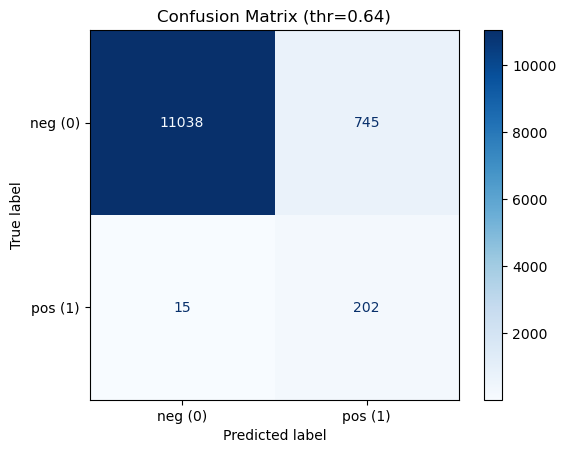

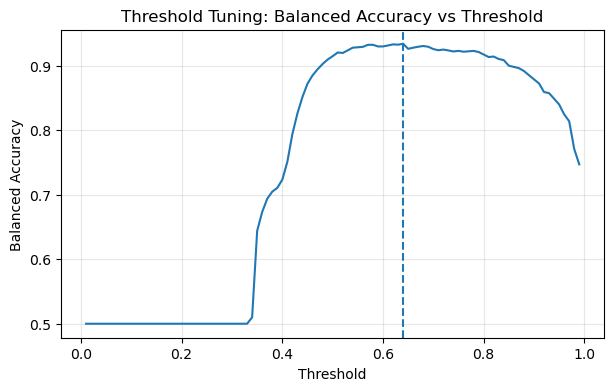

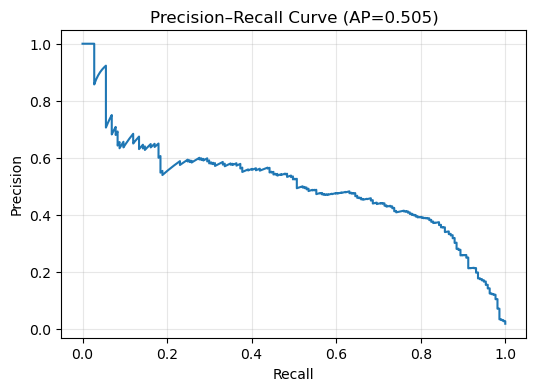

In [ ]:
print("Best val balanced accuracy:", model.best_val_bacc_)
print("Best threshold:", model.best_threshold_)
print("Val balanced accuracy:", balanced_accuracy_score(y_val_1d, val_preds))
print("Confusion matrix:\n", confusion_matrix(y_val_1d, val_preds))
print(classification_report(y_val_1d, val_preds, digits=4))


ConfusionMatrixDisplay.from_predictions(
    y_val_1d, val_preds,
    display_labels=["neg (0)", "pos (1)"],
    values_format="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix (thr={model.best_threshold_:.2f})")
plt.show()

thresholds = np.linspace(0.01, 0.99, 99)
baccs = np.array([
    balanced_accuracy_score(y_val_1d, (proba_val >= t).astype(int))
    for t in thresholds
])

plt.figure(figsize=(7,4))
plt.plot(thresholds, baccs)
plt.axvline(model.best_threshold_, linestyle="--")
plt.title("Threshold Tuning: Balanced Accuracy vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.grid(True, alpha=0.3)
plt.show()

# ---- 4) Precision–Recall curve ----
precision, recall, _ = precision_recall_curve(y_val_1d, proba_val)
ap = average_precision_score(y_val_1d, proba_val)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title(f"Precision–Recall Curve (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
scaler = RobustScaler()
scaler.set_output(transform="pandas")
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

Xtr_full = X_train_s.to_numpy().T
y_full = y_train.values.ravel().reshape(1, -1)

model = Model(seed=42)
pos_weight_full = (len(y_train) - y_train.sum().item()) / y_train.sum().item()

model.train(
    Xtr_full, y_full,
    iters=8000,
    alpha=5e-5,
    pos_weight=pos_weight_full,
    l2=1.0,
    l1=0.0,
    grad_clip=5.0
)

test_proba = model.predict_proba(X_test_s.to_numpy().T)
test_pred = (test_proba.ravel() >= model.best_threshold_).astype(int)  # if no val, use tuned threshold you chose

MAPPING = {1: 'pos', 0: 'neg'}
submission = pd.DataFrame({
    "Id": np.arange(len(test_pred)),
    "Prediction": pd.Series(test_pred).replace(MAPPING)
})

submission.to_csv("submission.csv", index=False)

Iteration 0: cost = 1.3612
Iteration 100: cost = 0.8707
Iteration 200: cost = 0.8521
Iteration 300: cost = 0.8389
Iteration 400: cost = 0.8285
Iteration 500: cost = 0.8201
Iteration 600: cost = 0.8129
Iteration 700: cost = 0.8066
Iteration 800: cost = 0.8009
Iteration 900: cost = 0.7958
Iteration 1000: cost = 0.7910
Iteration 1100: cost = 0.7866
Iteration 1200: cost = 0.7824
Iteration 1300: cost = 0.7784
Iteration 1400: cost = 0.7746
Iteration 1500: cost = 0.7709
Iteration 1600: cost = 0.7674
Iteration 1700: cost = 0.7641
Iteration 1800: cost = 0.7608
Iteration 1900: cost = 0.7576
Iteration 2000: cost = 0.7545
Iteration 2100: cost = 0.7515
Iteration 2200: cost = 0.7485
Iteration 2300: cost = 0.7456
Iteration 2400: cost = 0.7428
Iteration 2500: cost = 0.7401
Iteration 2600: cost = 0.7374
Iteration 2700: cost = 0.7348
Iteration 2800: cost = 0.7322
Iteration 2900: cost = 0.7296
Iteration 3000: cost = 0.7272
Iteration 3100: cost = 0.7247
Iteration 3200: cost = 0.7223
Iteration 3300: cost =

In [ ]:
pos_pred = np.count_nonzero(test_pred==1)
neg_pred = np.count_nonzero(test_pred==0)
print(f"Positive predictions: {pos_pred}")
print(f"Negative predictions: {neg_pred}")

Positive predictions: 1437
Negative predictions: 14563
